In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import deque

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## L96 stuff

In [3]:
from L96 import *
from EnKF import *
from utils import *
from parameterizations import *
import gym

In [4]:
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')

In [195]:
class L96TwoLevelRL(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def step_with_B(self, B):

        k1_X = self._rhs_X_dt(self.X, B=B)
        k2_X = self._rhs_X_dt(self.X + k1_X / 2, B=B)
        k3_X = self._rhs_X_dt(self.X + k2_X / 2, B=B)
        k4_X = self._rhs_X_dt(self.X + k3_X, B=B)

        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)
        
#         self.X += B * self.dt

        self.step_count += 1
        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)
            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())

In [291]:
class L96Gym(gym.Env):
    def __init__(self, lead_time, X_init, Y_init, dt=0.01, action_bounds=(-20,20)):
        self.lead_time = lead_time
        self.X_init, self.Y_init = X_init, Y_init
        self.step_count = 0
        self.dt = dt
        self.nsteps = self.lead_time // self.dt
        
        self.l96_tru = L96TwoLevel(X_init=initX, Y_init=initY)
        self.l96_tru.iterate(lead_time)
        self.fc_target = self.l96_tru.X.copy()
        
        self.action_space = gym.spaces.Box(
            low=np.array([action_bounds[0]]), 
            high=np.array([action_bounds[1]])
        )
        self.observation_space = gym.spaces.Box(-np.array([np.inf]), np.array([np.inf]))
        
    
    def reset(self):
        self.l96 = L96TwoLevelRL(noYhist=True, X_init=initX, dt=self.dt, save_dt=self.dt)
        state = self.l96.X.copy()
        self.step_count = 0
        return state[:, None]
    
    def step(self, action):
        self.l96.step_with_B(action)
        state = self.l96.X.copy()
        self.step_count += 1
        if self.step_count >= self.nsteps:
            done = True
            reward = -((state - self.fc_target)**2).mean()
        else:
            done = False
            reward = 0
        return state[:, None], reward, done, None

## Use CUDA</h2>

In [7]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

## Replay Buffer</h2>

In [8]:
class ReplayBufferOld:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [70]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        if state.ndim == 1:
            self.buffer.append([state, action, reward, next_state, done])
        else:
            for i in range(len(state)):
                self.buffer.append([
                    state[i], action[i], reward, next_state[i], done])
#             for s, a, ns in zip(state, action, next_state):
#                 self.buffer.append([s, a, reward, ns, done])
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

<h2>Normalize action space</h2>

In [10]:
class NormalizedActions(gym.ActionWrapper):

    def _action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def _reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return actions

<h2>Ornstein-Uhlenbeck process</h2>
Adding time-correlated noise to the actions taken by the deterministic policy<br>
<a href="https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process">wiki</a>

In [11]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

In [12]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1> Continuous control with deep reinforcement learning</h1>
<h2><a href="https://arxiv.org/abs/1509.02971">Arxiv</a></h2>

In [386]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x
    
#     def get_action(self, state):
#         state  = torch.FloatTensor(state).unsqueeze(0).to(device)
#         action = self.forward(state)
#         return action.detach().cpu().numpy()[0, 0]
    def get_action(self, state):
        state = np.atleast_2d(state)
        state  = torch.FloatTensor(state).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy().squeeze()
    
class PolicyNetwork2(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork2, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
#     def get_action(self, state):
#         state  = torch.FloatTensor(state).unsqueeze(0).to(device)
#         action = self.forward(state)
#         return action.detach().cpu().numpy()[0, 0]
    def get_action(self, state):
        state = np.atleast_2d(state)
        state  = torch.FloatTensor(state).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy().squeeze()    

class PolicyNetworkLinear(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetworkLinear, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, num_actions, bias=True)
        self.linear1.weight.data.uniform_(-init_w, init_w)
        self.linear1.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        return self.linear1(state)
    
    def get_action(self, state):
        state = np.atleast_2d(state)
        state  = torch.FloatTensor(state).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy().squeeze()

<h2>DDPG Update</h2>

In [345]:
import pdb

In [355]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())

#     pdb.set_trace()
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [65]:
env = NormalizedActions(gym.make("MountainCarContinuous-v0"))
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [66]:
max_frames  = 20000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

In [67]:
while frame_idx < max_frames:
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
#         action = ou_noise.get_action(action, step)
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
    
    rewards.append(episode_reward)

KeyboardInterrupt: 

In [68]:
state, action, reward, next_state, done = replay_buffer.sample(batch_size)

In [69]:
state.shape, reward.shape

((128, 2), (128,))

In [ ]:
done = False
state=env.reset()
env.render()
while not done:
    action = policy_net.get_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    env.render()
env.close()

## L96 Version

In [371]:
def plot(episode, rewards, weights, biases):
    clear_output(True)
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].set_title('frame %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    axs[0].plot(rewards)
    axs[1].set_title('weight')
    axs[1].plot(weights)
    #axs[1].axhline(slope, c='gray')
    #axs[1].set_yscale('log')
    axs[2].set_title('bias')
    axs[2].plot(biases)
    #axs[2].axhline(intercept, c='gray')
    plt.show()

In [372]:
#env = NormalizedActions(L96Gym(1, initX, initY))
env = L96Gym(1, initX, initY)
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetworkLinear(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetworkLinear(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [373]:
policy_net.linear1.weight.cpu().detach().numpy()[0]

array([-0.00164174], dtype=float32)

In [374]:
max_frames  = 20000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128
weights = []
biases = []

In [375]:
action.shape

(36,)

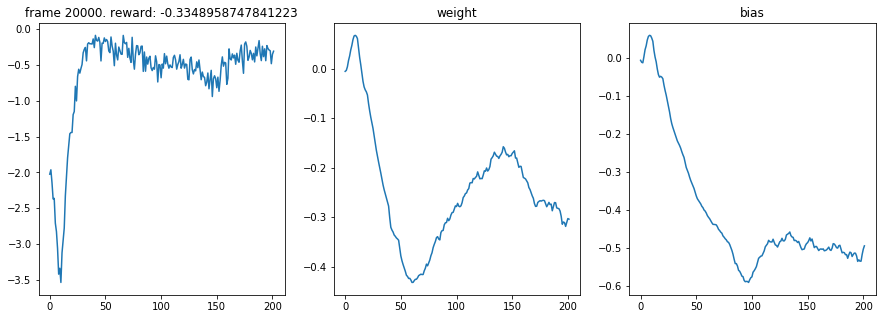

In [376]:
episode = 0
noise_slope = np.random.normal(1, 0.1)
noise_bias = np.random.normal(0, 0.1)
while frame_idx < max_frames:
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
#         action = ou_noise.get_action(action, step)
        action = action * noise_slope + noise_bias
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action[:, None], reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards, weights, biases)
        
        if done:
            weights.append(policy_net.linear1.weight.cpu().detach().numpy()[0].copy())
            biases.append(policy_net.linear1.bias.cpu().detach().numpy()[0].copy())
            episode += 1
            noise_slope = np.random.normal(1, 0.1)
            noise_bias = np.random.normal(0, 0.1)
            break
    
    rewards.append(episode_reward)

## with a real NN

In [387]:
#env = NormalizedActions(L96Gym(1, initX, initY))
env = L96Gym(1, initX, initY)
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork2(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork2(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [388]:
policy_net.linear1.weight.cpu().detach().numpy()[0]

array([-0.59904075], dtype=float32)

In [389]:
max_frames  = 20000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128
weights = []
biases = []

In [390]:
action.shape

(36,)

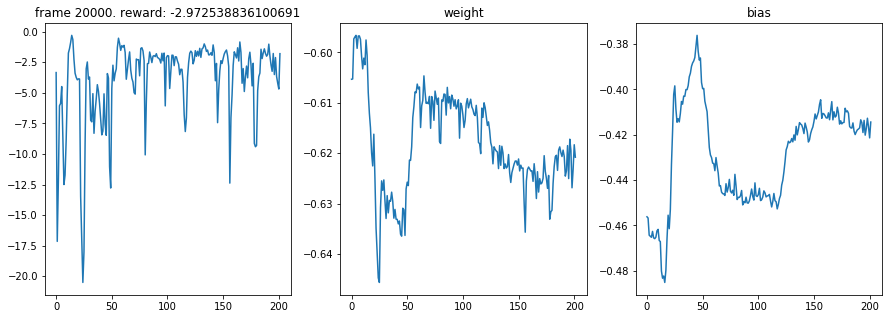

In [391]:
episode = 0
noise_slope = np.random.normal(1, 0.1)
noise_bias = np.random.normal(0, 0.1)
while frame_idx < max_frames:
    state = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
#         action = ou_noise.get_action(action, step)
        action = action * noise_slope + noise_bias
        next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action[:, None], reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards, weights, biases)
        
        if done:
            weights.append(policy_net.linear1.weight.cpu().detach().numpy()[0].copy())
            biases.append(policy_net.linear1.bias.cpu().detach().numpy()[0].copy())
            episode += 1
            noise_slope = np.random.normal(1, 0.1)
            noise_bias = np.random.normal(0, 0.1)
            break
    
    rewards.append(episode_reward)

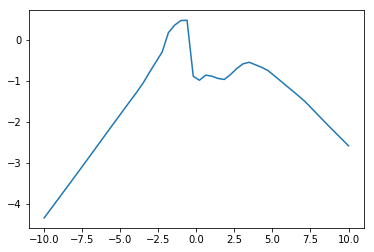

In [392]:
a = np.linspace(-10,10)
b = policy_net.get_action(a[:, None])
plt.plot(a, b)

## Sanity Check

In [314]:
env = L96Gym(1, initX, initY)
state = env.reset()

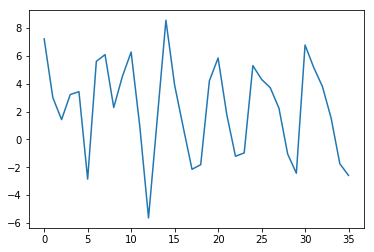

In [315]:
plt.plot(state)

In [316]:
policy_net = PolicyNetworkLinear(state_dim, action_dim, hidden_dim).to(device)

In [317]:
policy_net.linear1.weight, policy_net.linear1.bias

(Parameter containing:
 tensor([[-0.0011]], requires_grad=True), Parameter containing:
 tensor([-0.0008], requires_grad=True))

In [318]:
policy_net.linear1.weight.data = torch.tensor([[-0.5]])

In [319]:
policy_net.linear1.bias.data = torch.tensor([-0.2])

In [320]:
action = policy_net.get_action(state)

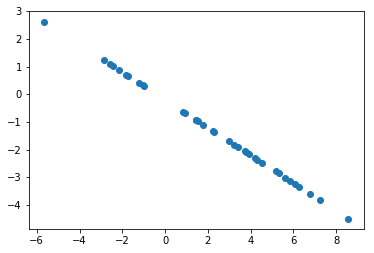

In [321]:
plt.scatter(state, action)

In [322]:
next_state, reward, done, _ = env.step(action)

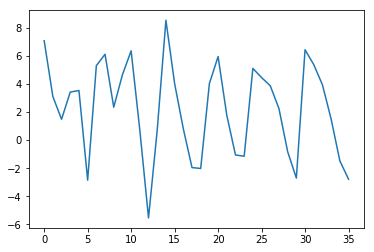

In [323]:
plt.plot(next_state)

In [324]:
reward

0

In [325]:
done = False
state = env.reset()
states = [state.copy()]
while not done:
    action = policy_net.get_action(state)
#     action = ou_noise.get_action(action, step)
    next_state, reward, done, _ = env.step(action)
    state = next_state.copy()
    states.append(state.copy())

In [326]:
states = np.array(states); states.shape

(100, 36, 1)

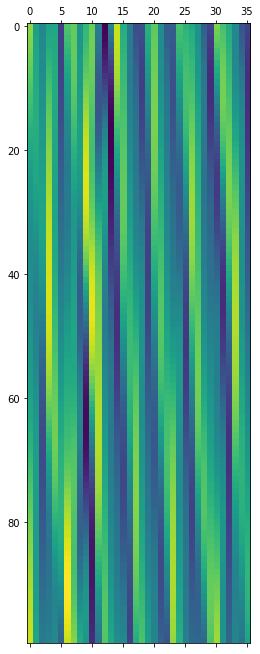

In [327]:
plt.matshow(states.squeeze())

In [233]:
class NNParam():
    def __init__(self, net):
        self.net = net
    def __call__(self, x):
        x = torch.FloatTensor(x)[:, None].to(device)
        return self.net(x).cpu().detach().numpy().squeeze(-1)

In [250]:
nn_param = NNParam(policy_net)

In [251]:
l96_param = L96TwoLevelRL(noYhist=True, parameterization=nn_param, X_init=initX, Y_init=initY,
                          dt=0.01, save_dt=0.01)

In [252]:
B = nn_param(l96_param.X)

In [253]:
l96_param.iterate(1)

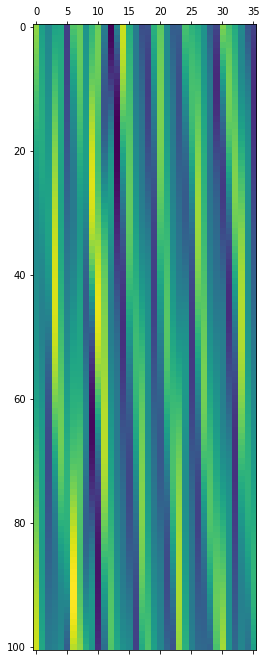

In [254]:
plt.matshow(l96_param.history.X)

In [272]:
l96_param2 = L96TwoLevelRL(noYhist=True, X_init=initX,
                          dt=0.01, save_dt=0.01)

In [273]:
for i in range(100):
    action = policy_net.get_action(l96_param2.X[:, None])
    B = nn_param(l96_param2.X)
    l96_param2.step_with_B(action)

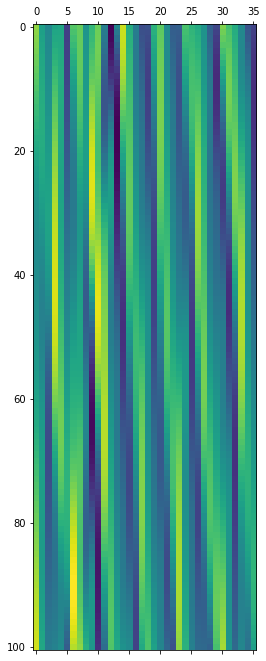

In [274]:
plt.matshow(l96_param2.history.X)

In [308]:
env = NormalizedActions(L96Gym(1, initX, initY))
state = env.reset()
l96_param2 = L96TwoLevelRL(noYhist=True, X_init=initX,
                          dt=0.01, save_dt=0.01)

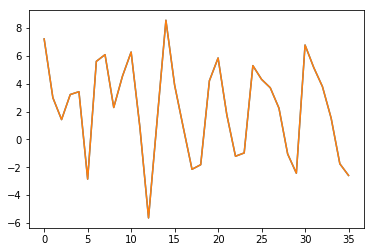

In [309]:
plt.plot(env.l96.X)
plt.plot(l96_param2.X)

In [310]:
B = nn_param(l96_param2.X)
action = policy_net.get_action(state)

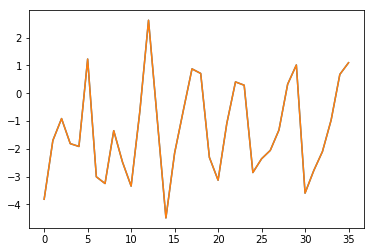

In [311]:
plt.plot(B)
plt.plot(action)

In [312]:
l96_param2.step_with_B(B)
#next_state, reward, done, _ = env.step(action)
env.l96.step_with_B(action)

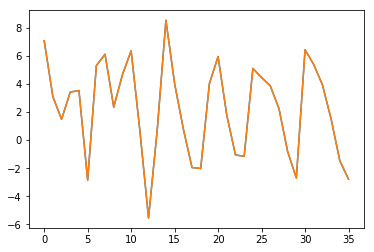

In [313]:
plt.plot(env.l96.X)
plt.plot(l96_param2.X)

In [295]:
states = [state.copy()]
for i in range(100):
    B = nn_param(l96_param2.X)
    l96_param2.step_with_B(action)
    
    action = policy_net.get_action(state)
#     action = ou_noise.get_action(action, step)
    next_state, reward, done, _ = env.step(action)
    state = next_state.copy()
    states.append(state.copy())

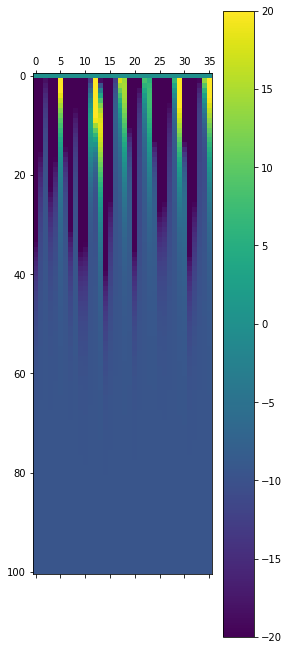

In [300]:
plt.matshow(env.l96.history.B)
plt.colorbar()

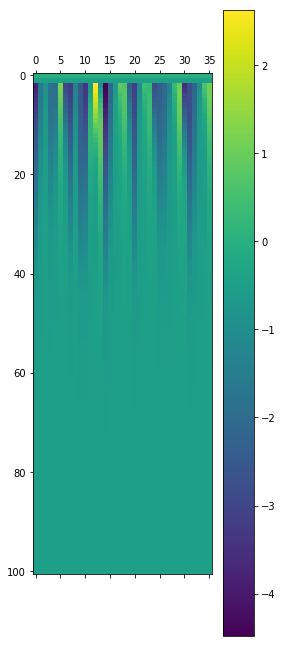

In [301]:
plt.matshow(l96_param2.history.B)
plt.colorbar()

In [245]:
l96_param.history.X

<xarray.DataArray 'X' (time: 11, x: 36)>
array([[ 7.222185,  2.998545,  1.425022, ...,  1.52826 , -1.750165, -2.589946],
       [ 5.505031,  3.818751,  2.033615, ...,  2.008367,  0.842404, -3.61788 ],
       [ 3.530386,  3.807232,  2.801626, ...,  4.064892,  2.133322, -3.15538 ],
       ...,
       [ 6.382326,  2.858734, -1.364562, ...,  2.47328 ,  3.966398,  3.922869],
       [ 7.740425,  2.882591, -0.267675, ...,  1.122381,  2.130638,  4.468181],
       [ 8.643765,  3.585194,  0.789074, ...,  1.361167,  0.150997,  3.090658]])
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35

In [238]:
l96_tru = L96TwoLevel(X_init=initX, Y_init=initY)
l96_tru.iterate(1)

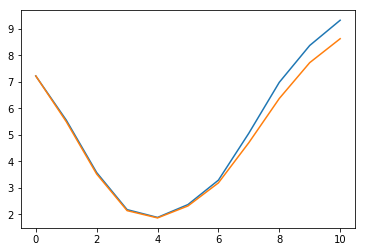

In [239]:
plt.plot(l96_tru.history.X[:, 0])
plt.plot(l96_param.history.X[:, 0])

In [175]:
reward

-2.057357377440274

In [157]:
reward

-13.501346363827466

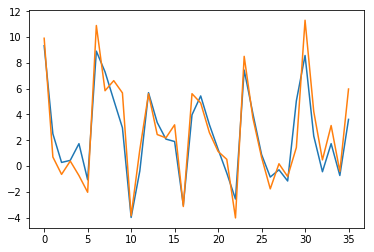

In [176]:
plt.plot(env.fc_target)
plt.plot(next_state)

In [111]:
params = policy_net.parameters()

([<matplotlib.lines.Line2D at 0x12ddbb4e0>],
 [<matplotlib.lines.Line2D at 0x12ddbb978>])

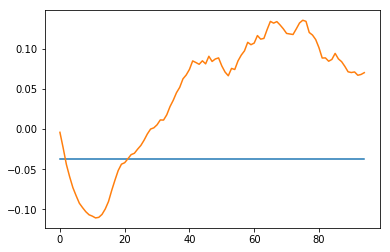

In [106]:
plt.plot(np.array(weights)), plt.plot(np.array(biases))

In [96]:
done

True

In [94]:
frame_idx

1402

In [95]:
len(rewards)

1303

In [88]:
len(replay_buffer)

259920

In [84]:
action = policy_net.get_action(state)

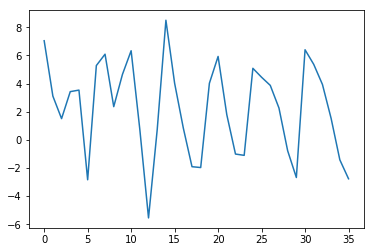

In [83]:
plt.plot(state)

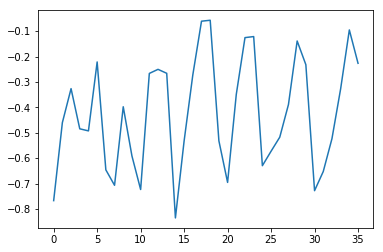

In [85]:
plt.plot(action)

In [86]:
action = ou_noise.get_action(action, step)

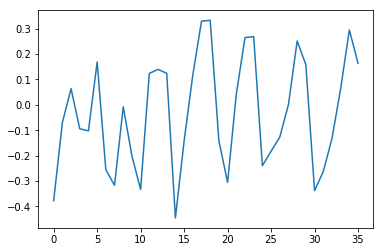

In [87]:
plt.plot(action)